# CESM2 LE2 ensemble analysis 1979-2050

Things to look at
- Present-day period versus future projection: thermocline, temperature and salinity on shelf / in cavity
- Basal mass loss projections --- calculate as difference with respect to present-day
- Ensemble spread
- Do SF-GHG and SF-EE ensemble members clearly separate from LE2 ensemble
- Significance test

In [1]:
import xarray as xr
import numpy as np
import cmocean
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.diagnostics import isosurface
from nemo_python_git.grid import region_mask

#### Runs to analyze

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
era5dir  = f'{base_dir}output/ERA5_1h_tune0_efr020/'
LE2_ensemble_membs = ['1011','1031','1051','1071','1091']
GHG_ensemble_membs = ['001']
EE_ensemble_membs  = ['101']

In [3]:
region_names = ['amundsen_sea','bellingshausen_sea','pine_island', 'thwaites', 'getz','dotson_crosson','larsen','filchner_ronne','ross', 'amery', 'all']
var_names    = ['shelf_temp_btw_200_700m', 'shelf_salt_btw_200_700m', 'bwtemp', 'bwsalt', \
                 'cavity_temp', 'cavity_salt', 'shelf_temp', 'shelf_salt', 'cavity_thermocline', 'shelf_thermocline', 'thermocline']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]

Variables who's timeseries I want to investigate:
- Amundsen Sea, Ross Sea, and Bellingshausen Sea: thermocline, shelf_temp_btw_200_700m, shelf_salt_btw_200_700m

In [4]:
def timeseries_shelf_cavity_thermocline(region, region_name='', ylim=(None,None), era5=False):
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    fig.suptitle(region_name)
    labels=['Continental shelf', 'Ice-shelf cavity']
    background_colors=['gray', '#87CEFA']
    color=['#444444','#23649e']
    
    for v, var in enumerate([f'{region}_shelf_thermocline', f'{region}_cavity_thermocline']):
        for e, ens in enumerate(LE2_ensemble_membs):
            ds = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens{ens}/timeseries0-gridT.nc')
        
            ax.plot(ds['time_counter'], ds[var], c=background_colors[v],linewidth=0.8) 
            ds['time_counter'] = ds['time_counter'].values.astype("float64")
            if e==0:
                shelf_sum = ds[var]
                num_ens   = xr.where(~np.isnan(shelf_sum), 1, 0)
            else:
                da_reshaped = ds[var].reindex_like(shelf_sum, fill_value=0)
                shelf_sum   = shelf_sum + da_reshaped
                num_ens     = num_ens + xr.where(da_reshaped==0, 0, 1)

        annual_mean_time   = shelf_sum['time_centered'].groupby('time_centered.year').mean()
        annual_mean_thermo = (shelf_sum/num_ens).groupby('time_centered.year').mean()
        ax.plot(annual_mean_time, annual_mean_thermo, '-', c=color[v], linewidth=1.5, label=labels[v])

        if era5:
            ds_era5 = xr.open_dataset(f'{base_dir}output/ERA5_1h_tune0_efr020/timeseries1-gridT-old.nc')
            if v==1: label='ERA5'
            else: label='_no_legend_'
            ax.plot(ds_era5['time_counter'], ds_era5[var], c=color[v], linestyle='--', linewidth=1.0, label=label) 
            
    ax.set_ylabel('Thermocline')
    ax.legend(frameon=False, loc=(1.05, 0.4))
    ax.set_ylim(ylim[0],ylim[1])

    return fig, ax

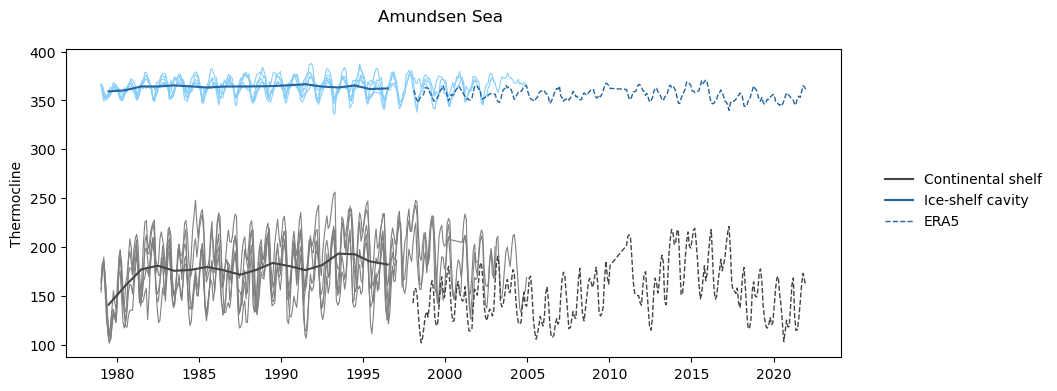

In [15]:
fig, ax = timeseries_shelf_cavity_thermocline('amundsen_sea', region_name='Amundsen Sea', era5=True)

In [6]:
def timeseries_shelf_cavity_TS(region, region_name='', era5=False, annual=False):
    fig, ax = plt.subplots(1,2, figsize=(20,4))
    fig.suptitle(region_name)
    labels=['Continental shelf, 200-700 m', 'Ice-shelf cavity', 'Continental shelf, 200-700 m', 'Ice-shelf cavity']
    background_colors=['#b4b4b4', '#87CEFA', '#b4b4b4', '#87CEFA']
    color=['#444444','#23649e', '#444444','#23649e']
    
    for v, var in enumerate([f'{region}_shelf_temp_btw_200_700m', f'{region}_cavity_temp', f'{region}_shelf_salt_btw_200_700m', f'{region}_cavity_salt']):
        if v < 2:
            axis=ax[0]
        else:
            axis=ax[1]
            
        for e, ens in enumerate(LE2_ensemble_membs):
            ds = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens{ens}/timeseries0-gridT.nc')
            if annual:
                ds=ds.resample(time_centered='YS').mean()
        
            axis.plot(ds['time_centered'], ds[var], c=background_colors[v],linewidth=0.6) 
            
            if e==0:
                shelf_sum = ds[var]
                num_ens   = xr.where(~np.isnan(shelf_sum), 1, 0)
            else:
                da_reshaped = ds[var].reindex_like(shelf_sum, fill_value=0)
                shelf_sum   = shelf_sum + da_reshaped
                num_ens     = num_ens + xr.where(da_reshaped==0, 0, 1)
    
        axis.plot(shelf_sum['time_centered'], shelf_sum/num_ens, '-', c=color[v], linewidth=1.5, label=labels[v])

        if era5:
            ds_era5 = xr.open_dataset(f'{base_dir}output/ERA5_1h_tune0_efr020/timeseries1-gridT-old.nc')
            if annual:
                ds_era5=ds_era5.resample(time_centered='YS').mean()
            if v==1: label='ERA5'
            else: label='_no_legend_'
            axis.plot(ds_era5['time_centered'], ds_era5[var], c=color[v], linestyle='--', linewidth=1.0, label=label) 
        
    ax[0].set_ylabel('Conservative Temperature')
    ax[1].set_ylabel('Absolute Salinity')
    ax[0].legend(frameon=False)

    return fig, ax

IndentationError: unindent does not match any outer indentation level (<string>, line 29)

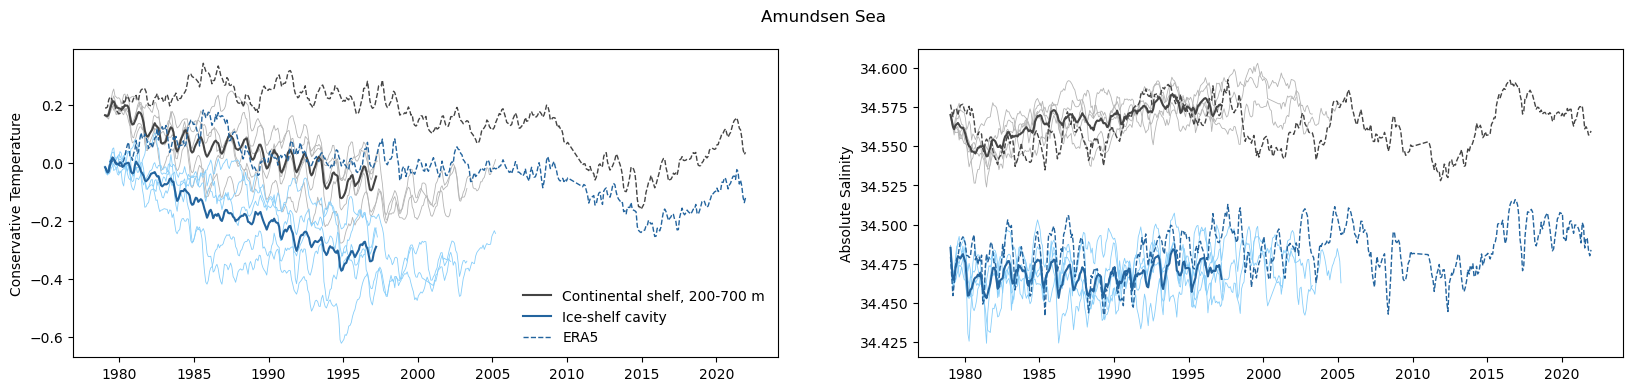

In [80]:
fig, ax = timeseries_shelf_cavity_TS('amundsen_sea', region_name='Amundsen Sea', era5=True, annual=False)

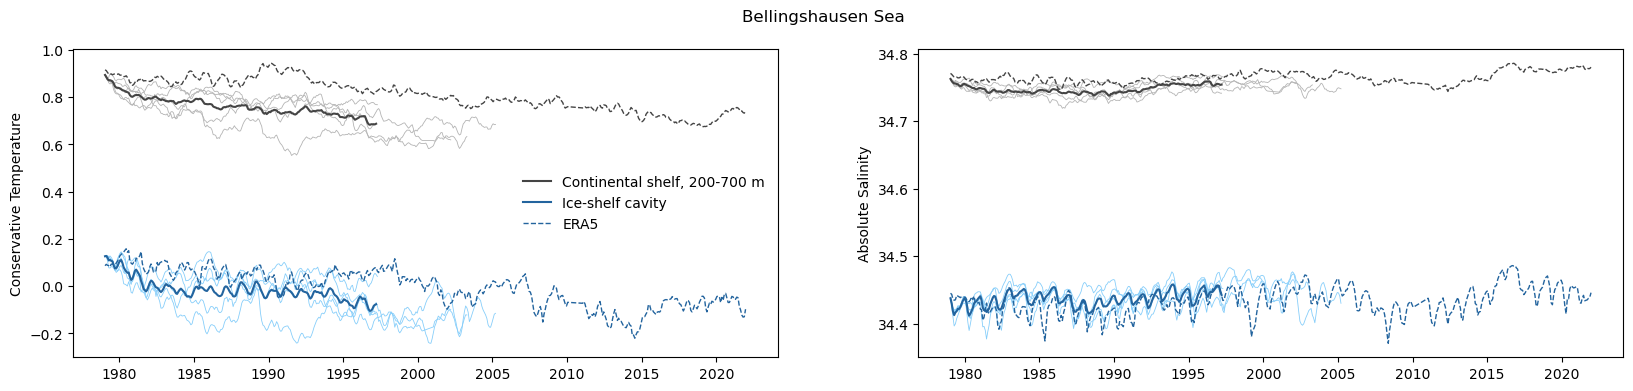

In [81]:
fig, ax = timeseries_shelf_cavity_TS('bellingshausen_sea', region_name='Bellingshausen Sea', era5=True, annual=False)

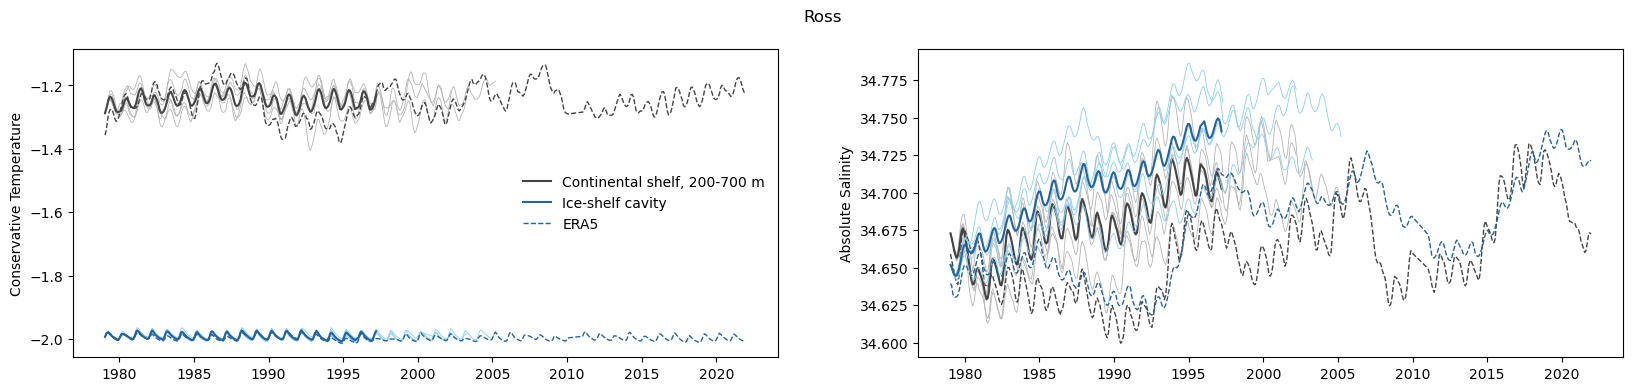

In [82]:
fig, ax = timeseries_shelf_cavity_TS('ross', region_name='Ross', era5=True, annual=False)

#### Calculate isotherm

In [9]:
xslice=slice(500,780)
yslice=slice(170,290)
# ds = xr.open_mfdataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens1091/files0/*grid_T*').rename({'x_grid_T':'x','y_grid_T':'y'}).isel(x=xslice,y=yslice)
ds = xr.open_mfdataset(f'{base_dir}output/ERA5_1h_tune0_efr020/files1/*grid_T*').rename({'x_grid_T':'x','y_grid_T':'y'}).isel(x=xslice,y=yslice)
domain_cfg = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20260108.nc').squeeze()

In [11]:
mask, ds_nemo = region_mask('amundsen_sea', domain_cfg)

In [12]:
mask_subset = mask.isel(x=xslice,y=yslice)

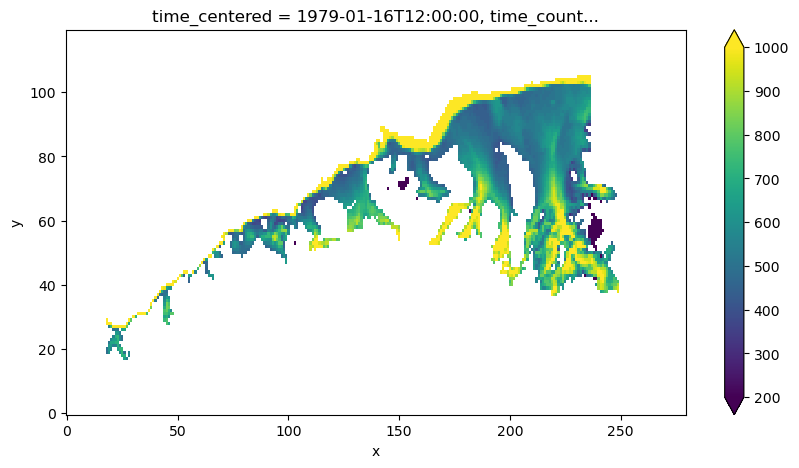

In [40]:
isosurface(ds['thetao'], 0.5, 'deptht').where(mask_subset==1).isel(time_counter=0).plot(vmin=200, vmax=1000, figsize=(10,5))

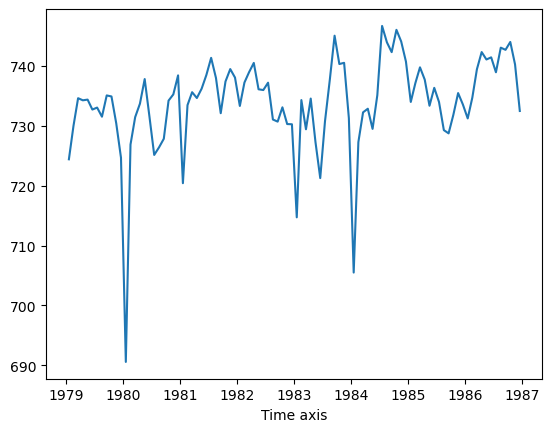

In [18]:
#CESM2
isosurface(ds['thetao'], 0.5, 'deptht').where(mask_subset==1).mean(dim=['x','y']).plot()

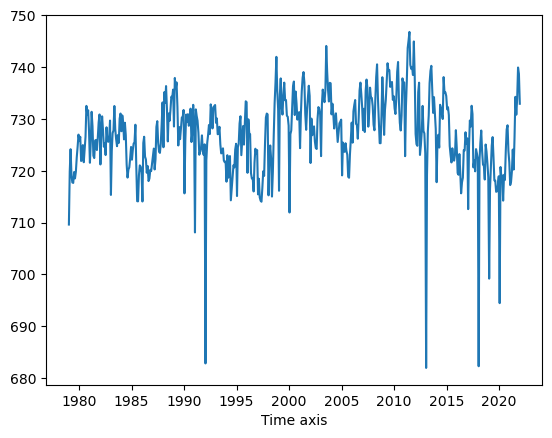

In [21]:
#ERA5
isosurface(ds['thetao'], 0.5, 'deptht').where(mask_subset==1).mean(dim=['x','y']).plot()

Could do something similar for the pycnocline

### Basal mass loss projections

In [4]:
def plot_multiple_experiments(experiment_sets, var, expts, annual_mean=False, gtype='T', shade_range=False):

    fig, ax = plt.subplots(1,1, figsize=(11,5))
    
    for expt in expts:
        
        data = xr.open_mfdataset([f'{dirpath}timeseries_{gtype}.nc' for dirpath in experiment_sets[expt]['path']], 
                                 combine='nested', concat_dim='ensemble_member', join='outer', coords='minimal', compat='override')

        if annual_mean:
            data = data.resample(time_centered='YS').mean()
        
        plot_experiment_set(data[var], expt, experiment_sets[expt]['color'], ax, shade_range=shade_range)
    ax.legend(frameon=False, loc=(1.05, 0.4), title='Experiment set')
    ax.axvline(pd.Timestamp('2014-12-31'), c='k', linestyle='--')
    ax.text(pd.Timestamp('2015-06-15'), (ax.get_ylim()[1]-ax.get_ylim()[0])*0.98+ax.get_ylim()[0], 'SSP 3-7.0 -->', verticalalignment='top')    
    
    return fig, ax

In [5]:
def plot_experiment_set(da, expt_name, color, ax, label_mean=True, shade_range=False):
    """
    Plots individual members as thin lines and the ensemble mean as a thick line.
    """
    linestyle = '--' if expt_name == 'ERA5' else '-'

    # 1. Handle Ensemble Spread (Lines of individual members vs. Shading)    
    if shade_range:
        # Calculate min and max across the ensemble dimension
        expt_min = da.min(dim='ensemble_member')
        expt_max = da.max(dim='ensemble_member')
        
        # Fill the area between min and max
        ax.fill_between(da.time_centered, expt_min, expt_max, color=color, alpha=0.2, edgecolor='none')
    else:
        # Original behavior: Plot individual members
        da.plot.line(ax=ax, x='time_centered', hue='ensemble_member', add_legend=False, color=color, alpha=0.3, linewidth=0.8, linestyle=linestyle)
        
    # 2. Calculate and plot the mean (thick, solid line)
    expt_mean = da.sel(time_centered=slice("1900-01-01","2050-12-31")).mean(dim='ensemble_member')
    expt_mean.plot.line(ax=ax, x='time_centered', color=color, linewidth=1.5, linestyle=linestyle, label=expt_name if label_mean else None)
    try:
        da.sel(time_centered=slice("2050-12-31",None)).plot.line(ax=ax, x='time_centered', hue='ensemble_member', add_legend=False, color=color, alpha=0.3, linewidth=0.8, linestyle='--')
    except:
        pass

    ax.set_xlabel('')
    try:
        ax.set_title(f"{da.long_name.split('for')[1]}")
    except: 
        pass
        
    ax.set_ylabel(f"{da.long_name.split('for')[0]} ({da.units})")

    return

In [7]:
# paths to experiment results
experiment_sets = {
    'LE2':{'path': [f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2_3hwind_1979_t0_0955_ens{ens}/' for ens in LE2_ensemble_membs],
           'color': '#444444'},
    'GHG':{'path': [f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2_SF-GHG_1979_t0_0955_ens{ens}/' for ens in GHG_ensemble_membs], 
           'color': '#e24a33'},
    'EE' :{'path': [f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2_SF-EE_1979_t0_0955_ens{ens}/' for ens in EE_ensemble_membs],
           'color': '#33cbe2'},
    'ERA5':{'path': ['/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_1h_tune0_efr020/'],
           'color': '#444444'}
}

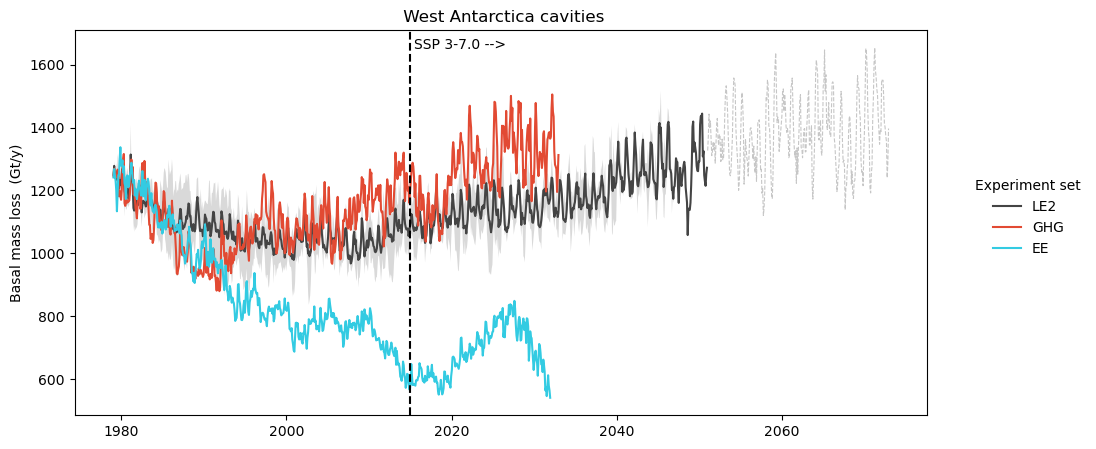

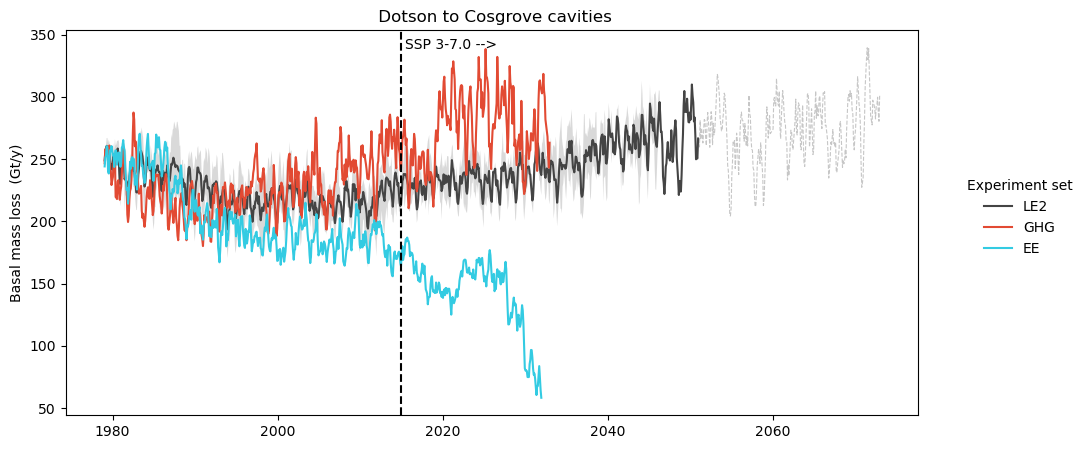

In [13]:
fig, ax = plot_multiple_experiments(experiment_sets, 'west_antarctica_massloss', ['LE2','GHG','EE'], annual_mean=False, shade_range=True)
fig, ax = plot_multiple_experiments(experiment_sets, 'dotson_cosgrove_massloss', ['LE2','GHG','EE'], annual_mean=False, shade_range=True)
# fig, ax = plot_multiple_experiments('getz_massloss', ['LE2','GHG','EE','ERA5'], annual_mean=False)

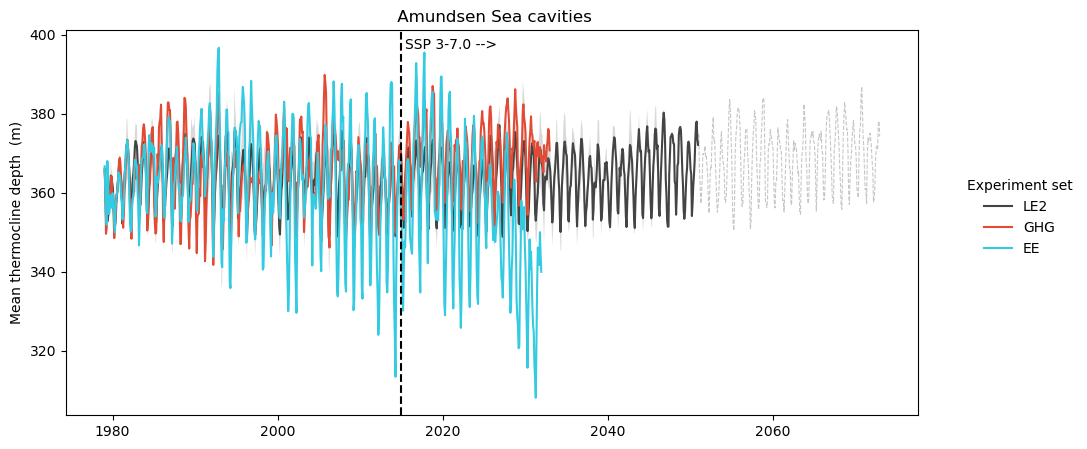

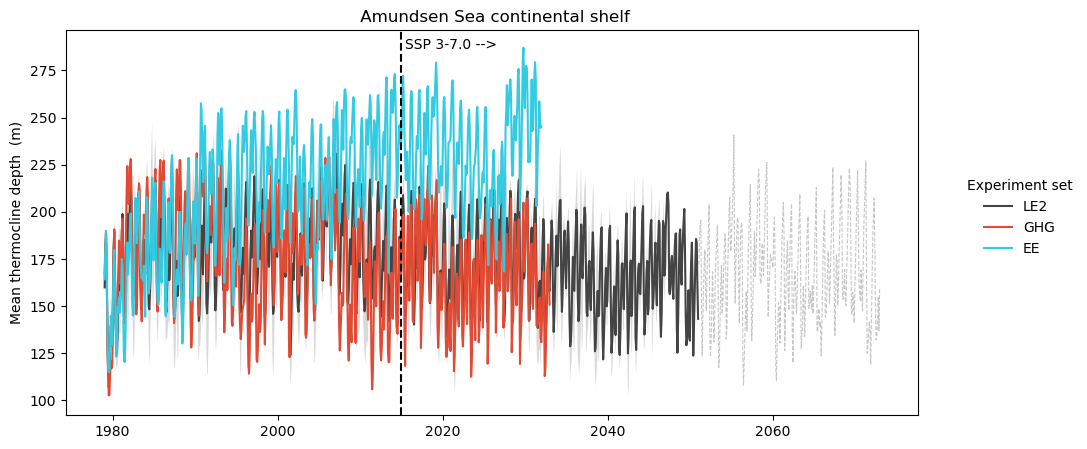

In [14]:
fig, ax = plot_multiple_experiments(experiment_sets, 'amundsen_sea_cavity_thermocline', ['LE2','GHG','EE'], annual_mean=False, shade_range=True)
fig, ax = plot_multiple_experiments(experiment_sets, 'amundsen_sea_shelf_thermocline', ['LE2','GHG','EE'], annual_mean=False, shade_range=True)

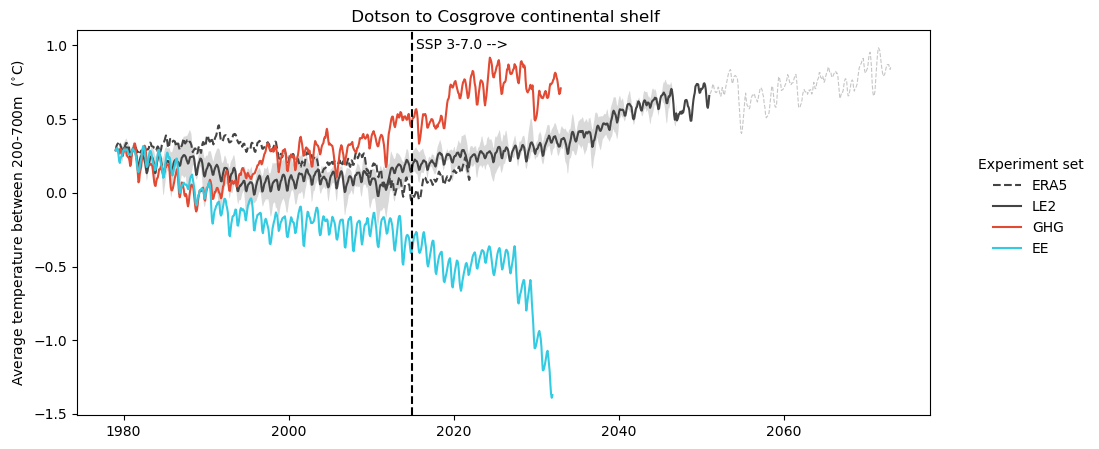

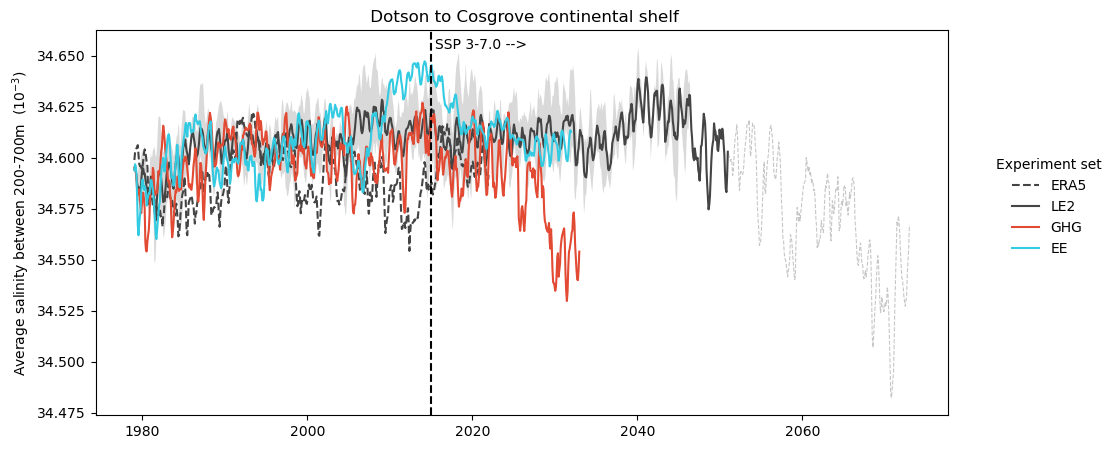

In [15]:
fig, ax = plot_multiple_experiments(experiment_sets, 'dotson_cosgrove_shelf_temp_btw_200_700m', ['ERA5','LE2','GHG','EE'], annual_mean=False, shade_range=True)
fig, ax = plot_multiple_experiments(experiment_sets, 'dotson_cosgrove_shelf_salt_btw_200_700m', ['ERA5','LE2','GHG','EE'], annual_mean=False, shade_range=True)

In [11]:
# paths to experiment results
experiment_sets = {
    'LE2':{'path': [f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2_3hwind_1979_t0_0955_ens{ens}/' for ens in [memb for memb in LE2_ensemble_membs if memb != '1031']],
           'color': '#444444'},
    'GHG':{'path': [f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2_SF-GHG_1979_t0_0955_ens{ens}/' for ens in GHG_ensemble_membs], 
           'color': '#e24a33'},
    'EE' :{'path': [f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2_SF-EE_1979_t0_0955_ens{ens}/' for ens in EE_ensemble_membs],
           'color': '#33cbe2'},
    'ERA5':{'path': ['/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_1h_tune0_efr020/'],
           'color': '#444444'}
}

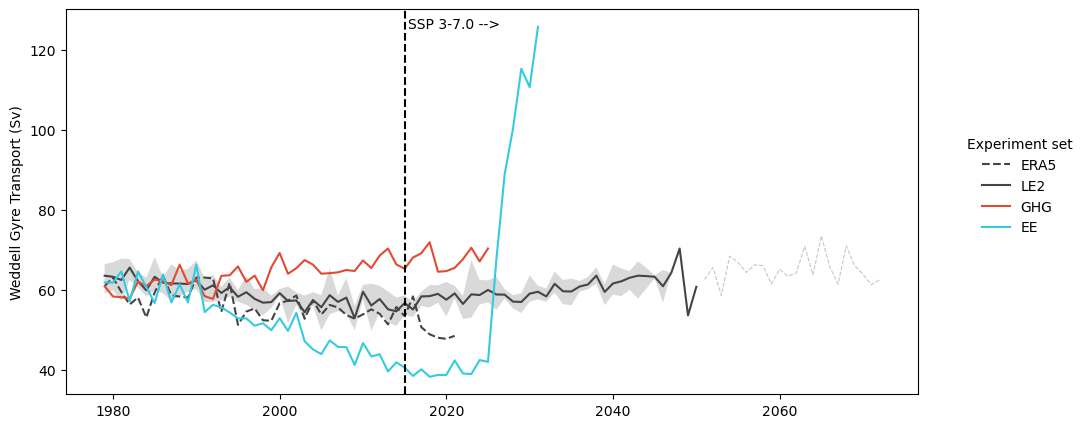

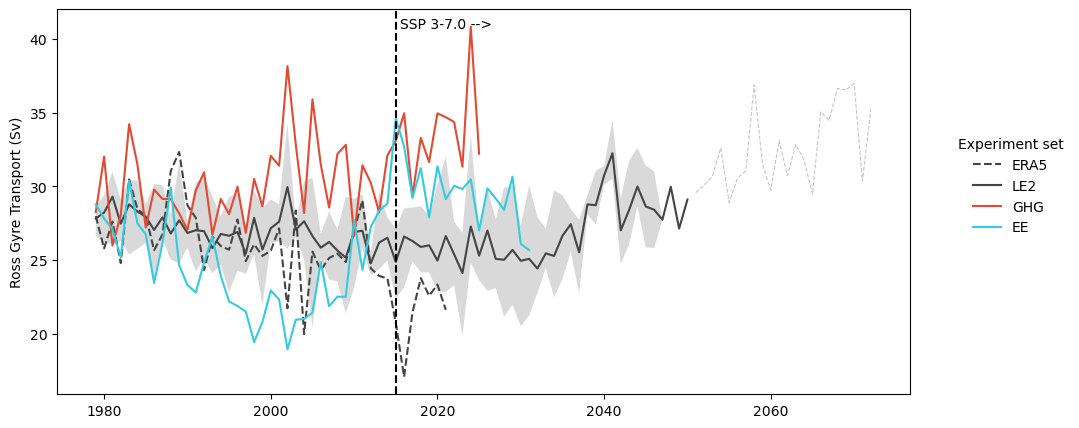

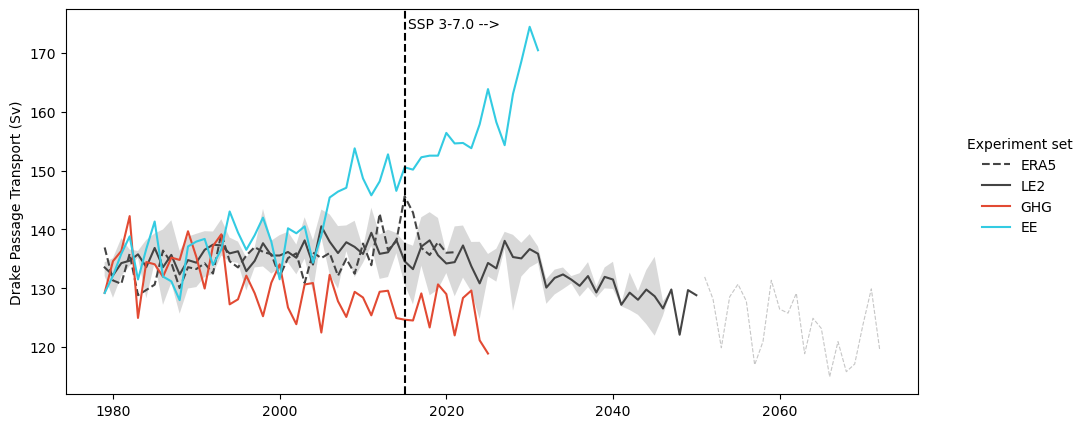

In [12]:
fig, ax = plot_multiple_experiments(experiment_sets, 'weddell_gyre_transport', ['ERA5','LE2','GHG','EE'], annual_mean=True, gtype='U', shade_range=True)
fig, ax = plot_multiple_experiments(experiment_sets, 'ross_gyre_transport', ['ERA5','LE2','GHG','EE'], annual_mean=True, gtype='U', shade_range=True)
fig, ax = plot_multiple_experiments(experiment_sets, 'drake_passage_transport', ['ERA5','LE2','GHG','EE'], annual_mean=True, gtype='U', shade_range=True)